# Setup

In [0]:
%%capture
%pip install poetry
%pip install git+https://github.com/oughtinc/ergo.git@993c959d4b5dc5b398f02b842407814b79619a42
%pip install xlrd


In [0]:
%load_ext google.colab.data_table

In [0]:
%%capture
import ergo
import numpy as np
import pandas as pd
import ssl
import math
import datetime
import warnings
import functools
from datetime import timedelta, date
from ergo.contrib.el_paso import *

In [0]:
warnings.filterwarnings(module="plotnine", action="ignore")
warnings.filterwarnings(module="jax", action="ignore")
ssl._create_default_https_context = ssl._create_unverified_context

In [0]:
metaculus = ergo.Metaculus(
    username="oughtpublic", 
    password="123456",
    api_domain = "pandemic"
)

# Ergo extensions

We'll define some helper functions that might get moved into Ergo in the future.

In [0]:
START_DATE = date(2020, 4, 1)


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


# Memoization

memoized_functions = []

def mem(func):
    func = functools.lru_cache(None)(func)
    memoized_functions.append(func)
    return func

def clear_mem():
    for func in memoized_functions:
        func.cache_clear()

# Associate models with questions

# We'll add a sampler here for each question we predict on. 
# Each sampler is a function that returns a single sample
# from our model predicting on that question.
samplers = {}

def question(question_id, community_weight=0):
    q = metaculus.get_question(question_id)

    def decorator(func):
        tag = func.__name__

        @functools.wraps(func)
        @mem
        def sampler():
            if ergo.flip(community_weight):
                value = q.sample_community()
            else:
                value = func()
            if isinstance(value, date):
                # FIXME: Ergo needs to handle dates
                ergo.tag(int((value - START_DATE).days), tag)
            else:
                ergo.tag(value, tag)
            return value
        sampler.question = q
        samplers[q.id] = sampler
        return sampler
    return decorator

def summarize_question_samples(samples):
    sampler_tags = [sampler.__name__ for sampler in samplers.values()]
    tags_to_show = [tag for tag in sampler_tags if tag in samples.columns]
    samples_to_show = samples[tags_to_show]
    summary = samples_to_show.describe().transpose().round(2)
    display(summary)

def plot_question(sampler, num_samples=200, bw=None):
  def model():
      clear_mem()
      sampler()

  samples = ergo.run(model, num_samples=num_samples)

  summarize_question_samples(samples)

  q = sampler.question

  q_samples = samples[sampler.__name__]

  if q.id == 4128: # Date question: Need to convert back to date from days (https://github.com/oughtinc/ergo/issues/144)
      q_samples = np.array([START_DATE + timedelta(s) for s in q_samples])

  if bw is not None:
      q.show_prediction(samples=q_samples, show_community=True, percent_kept=0.9, bw=bw)
  else:
      q.show_prediction(samples=q_samples, show_community=True, percent_kept=0.9)

# External data (cases, estimates, models)

## Texas government cases data

In [8]:
el_paso_cases = texas_data.get_el_paso_data()

el_paso_cases

,Cases so far,New cases
2020-03-04,0,NaN
2020-03-05,0,0
2020-03-06,0,0
2020-03-09,0,0
2020-03-10,0,0
2020-03-11,0,0
2020-03-12,0,0
2020-03-13,0,0
2020-03-15,1,1
2020-03-16,1,0


## @onlyasith's cases model



Pulled [here](https://docs.google.com/spreadsheets/d/1L6pzFAEJ6MfnUwt-ea6tetKyvdi0YubnK_70SGm436c/edit#gid=1807978187)

In [9]:
projected_cases = onlyasith.get_onlyasith_results()

projected_cases

,Cases so far,New cases
Date,,
2020-04-04,96,NaN
2020-04-05,106,10.0
2020-04-06,115,9.0
2020-04-07,125,10.0
2020-04-08,153,28.0
...,...,...
2020-09-30,1090,0.0
2020-10-01,1090,0.0
2020-10-02,1091,1.0


## @KrisMoore's compiled data

Pulled [here](https://docs.google.com/spreadsheets/d/1eGF9xYmDmvAkr-dCmd-N4efHzPyYEfVl0YmL9zBvH9Q/edit#gid=1694267458).

In [10]:
compiled_data = krismoore.get_krismoore_data()

compiled_data

,cases,new_cases,2_day_sma_new_cases,presumed_active_cases,fatalities,recovered,In hospital confirmed,in_icu,on_ventilator,tests_el_paso_dpt_public_health_only,new_tests_el_paso_dpt_public_health_only,tests_el_paso_inc_other_labs,tests_texas_all_sources,population
date,,,,,,,,,,,,,,
2020-03-04,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"952,366"
2020-03-05,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-06,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-07,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-30,887.0,30.0,29.0,535.0,18.0,352.0,52.0,27.0,17.0,1694.0,52.0,NaN,NaN,NaN
2020-05-01,924.0,37.0,33.5,506.0,21.0,418.0,53.0,31.0,13.0,1725.0,31.0,NaN,NaN,NaN
2020-05-02,961.0,37.0,37.0,520.0,22.0,441.0,53.0,30.0,16.0,1773.0,48.0,NaN,NaN,NaN


## @brachbach model (cases -> hospitalized)

In [0]:
get_daily_hospital_confirmed = brachbach.get_daily_hospital_confirmed

# Model components

In [0]:
@mem
def daily_infections(date: date) -> int:
    """
    What is the number of reported (new) Covid-19 infections on [date]?
    """
    try:
        # Look up Texas Government data
        new_cases = el_paso_cases.loc[date, "New cases"]
        if np.isnan(new_cases):
            raise KeyError
        return new_cases
    except KeyError:
        try:
            # Look up projections from @onlyasith's model
            cases = projected_cases.loc[date, "New cases"]
            if np.isnan(cases):
                raise KeyError
            
            # Add some (fairly arbitrary) uncertainty around this point estimate
            if cases == 0:
              return cases
            cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
            return np.clip(cases_estimate, cases * 0.5, cases * 2)
        except KeyError:
            # We're beyond the time range for data and model
            return 0

@mem
def mean_infections(start_date: date, end_date: date):
    """
    What is the average number of reported new infections for this range of 
    dates? (Including start date, excluding end date)
    """
    days = daterange(start_date, end_date)
    return np.mean([daily_infections(day) for day in days])

# Build @brachbach model
hospital_confirmed_from_daily_infected_model = get_daily_hospital_confirmed(compiled_data, daily_infections)

@mem
def hospital_confirmed_for_date(date: date) -> int:
    """
    The total number of lab-confirmed COVID-19 patients in El Paso County in
    the hospital on this date
    """
    try:
        # Look up in-hospital confirmed cases from @KrisMoore's compiled data
        new_hospital_confirmed = compiled_data.loc[date, "In hospital confirmed"]
        if np.isnan(new_hospital_confirmed):
            raise KeyError
        return new_hospital_confirmed
    except KeyError:
        try:
            # Get point estimate from @brachbach's regression model
            cases = hospital_confirmed_from_daily_infected_model(date)
            
            # Add some (fairly arbitrary) uncertainty around this point estimate
            if cases == 0:
              return cases
            cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
            return np.clip(cases_estimate, cases * 0.5, cases * 2)
        except KeyError:
            return 0

@mem
def frac_icu_ventilation():
    """
    Proportion of ICU admissions requiring ventilation

    Approach (PabloStafforini et al): 
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO: 
    - Improve how we use case data
    - Add qualitative adjustments
    """
    ventilation_pseudocounts = 25 + 17 + 0.05 * 1150 + 0.1 * 132
    icu_pseudocounts = 100 + 36 + 0.05 * 1300 + 0.1 * 196
    return ergo.beta_from_hits(ventilation_pseudocounts, icu_pseudocounts)

# El Paso questions

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,200.0,26.52,13.46,14.0,24.0,25.0,25.0,141.0


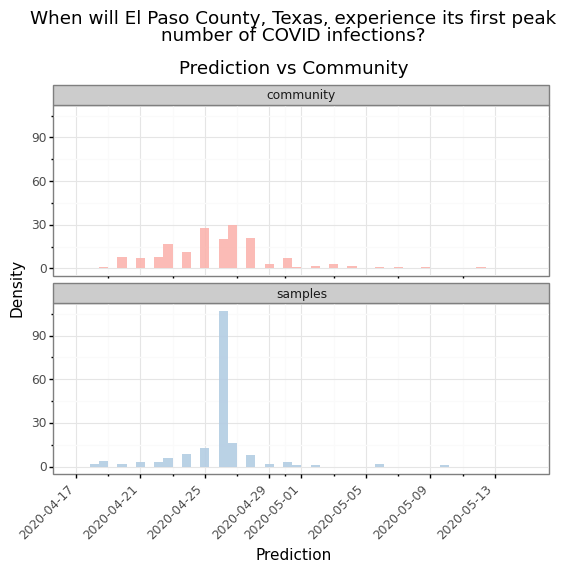

In [13]:
@question(4128, community_weight=0.5)
def peak_infection_date() -> date:
    """
    When will El Paso County, Texas, experience its first peak number of COVID
    infections?
    """    
    end_date = date(2020, 7, 1)
    for today in daterange(START_DATE, end_date):
        yesterday = today - timedelta(1)
        tomorrow = today + timedelta(1)
        two_day_mean = mean_infections(yesterday, tomorrow)
        future_means = [mean_infections(today + timedelta(i), today + timedelta(i+2)) for i in range(10)]
        if two_day_mean > max(future_means):
            return today
    return end_date
plot_question(peak_infection_date)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,95.0,28.36,19.05,15.0,25.00,25.00,25.0,134.00
peak_infections,200.0,237.20,934.28,0.0,56.49,73.17,74.0,6497.64


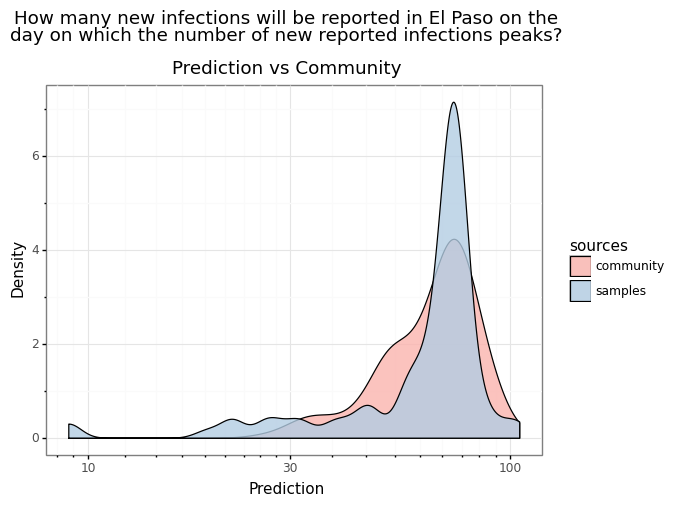

In [14]:
@question(4137, community_weight=0.5)
def peak_infections():
    """
    How many new infections will be reported in El Paso on the day on which
    the number of new reported infections peaks?
    """
    peak = peak_infection_date()
    return daily_infections(peak)
plot_question(peak_infections)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,104.0,26.01,12.87,14.00,24.00,25.00,25.00,145.00
mean_infections_peak345,200.0,38.88,115.28,0.59,25.45,31.25,31.67,1652.56


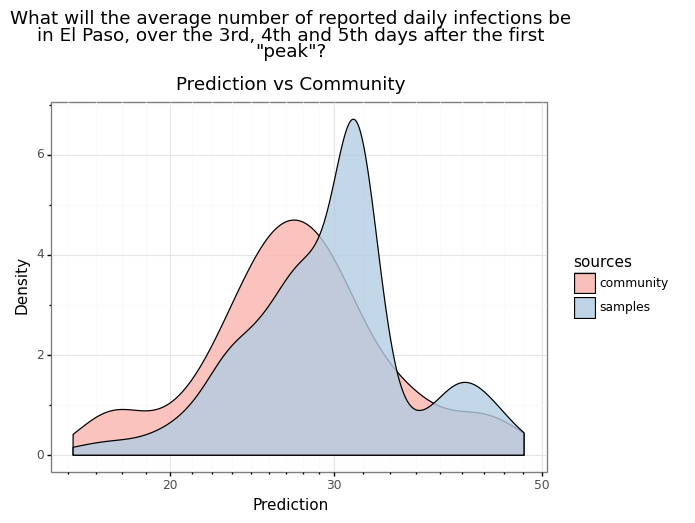

In [15]:
@question(4152, community_weight=0.5)
def mean_infections_peak345():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 3rd, 4th and 5th days after the first "peak"?
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(3), peak + timedelta(6))
plot_question(mean_infections_peak345)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,45.0,27.38,15.52,15.00,25.00,25.00,26.00,128.00
mean_infections_peak678,200.0,35.48,143.77,0.59,16.85,22.18,29.19,2049.08


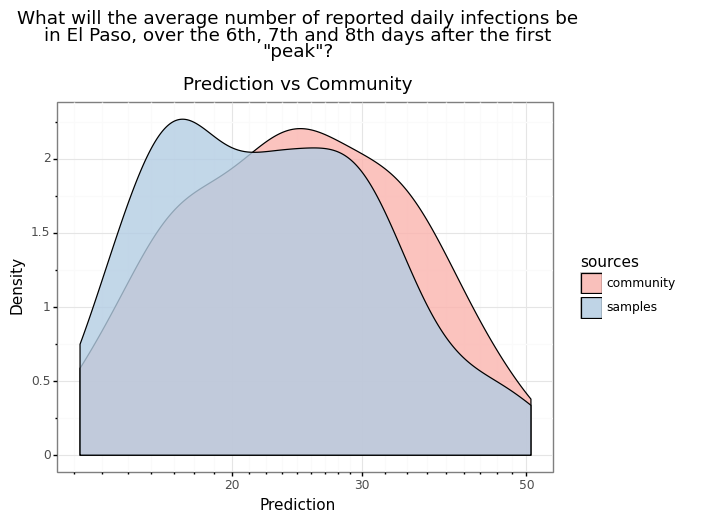

In [16]:

@question(4170, community_weight=0.8)
def mean_infections_peak678():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 6th, 7th and 8th days after the first "peak"?  
    """
    peak = peak_infection_date()
    return mean_infections(peak + timedelta(6), peak + timedelta(9))
plot_question(mean_infections_peak678)

,count,mean,std,min,25%,50%,75%,max
frac_patients_icu,200.0,0.31,0.1,0.06,0.24,0.3,0.37,0.74


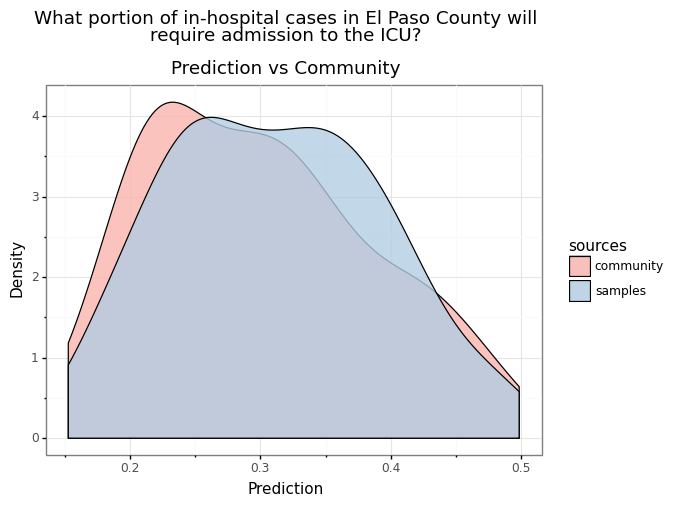

In [17]:
@question(4155, community_weight=0.7)
def frac_patients_icu():
    """
    What portion of in-hospital cases in El Paso County will require admission
    to the ICU?

    Following @katifish's approach:
    https://pandemic.metaculus.com/questions/4155/#comment-28054

    TODO: Add others from katifish comment
    """
    alpha = 0.1 # Rescaling counts becase we're more uncertain than implied by counts
    return ergo.random_choice([
      ergo.beta_from_hits(alpha * 121, alpha * 508),
      ergo.beta_from_hits(alpha * 181, alpha * 507),
    ])
plot_question(frac_patients_icu)

,count,mean,std,min,25%,50%,75%,max
frac_patients_icu,137.0,0.32,0.11,0.1,0.24,0.32,0.38,1.00
frac_patients_invasive,200.0,0.16,0.07,0.0,0.12,0.16,0.20,0.55


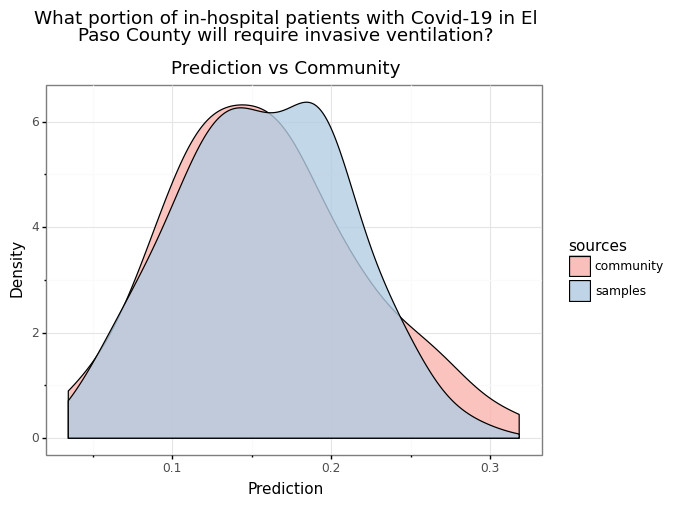

In [18]:
@question(4154, community_weight=0.3)
def frac_patients_invasive():
    """
    What portion of in-hospital patients with Covid-19 in El Paso County will
    require invasive ventilation?

    Following @PabloStafforini's indirect estimation approach:
    https://pandemic.metaculus.com/questions/4154/#comment-28155

    TODO:
    - Combine with direct estimate
      direct_estimate = ergo.beta_from_hits(0.1 * 130, 0.1 * 393)
    """
    return frac_patients_icu() * frac_icu_ventilation()
plot_question(frac_patients_invasive)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,142.0,25.89,10.94,15.00,24.0,25.0,25.0,139.00
max_30d_hospital_confirmed_for_peak,200.0,271.67,1456.29,1.29,65.0,65.0,65.0,14575.66


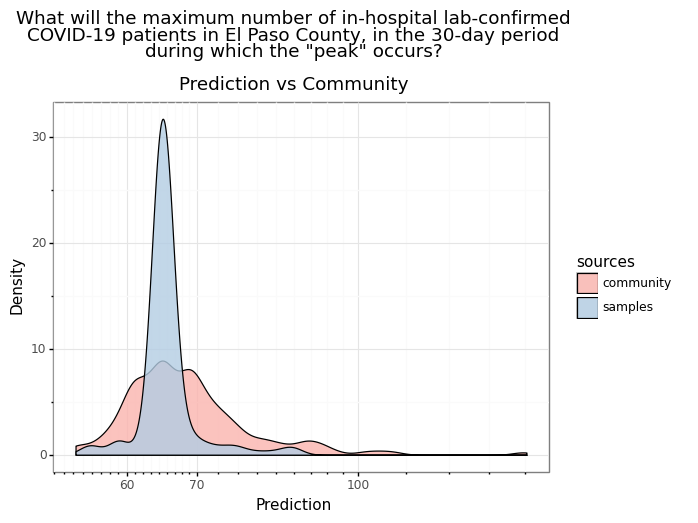

In [19]:
@question(4153, community_weight=0.3)
def max_30d_hospital_confirmed_for_peak():
    """
    What will the maximum number of in-hospital lab-confirmed COVID-19 
    patients in El Paso County, in the 30-day period during which the "peak"
    occurs?
    """
    peak = peak_infection_date()
    days = daterange(peak - timedelta(15), peak + timedelta(15))
    return max(hospital_confirmed_for_date(day) for day in days)

plot_question(max_30d_hospital_confirmed_for_peak, bw=0.01)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,136.0,27.33,16.86,14.00,25.00,25.00,25.00,137.00
frac_patients_icu,200.0,0.29,0.10,0.01,0.24,0.28,0.36,0.60
max_30d_hospital_confirmed_for_peak,200.0,124.30,609.76,1.21,65.00,65.00,65.00,7211.65
peak_icu_admissions,200.0,47.07,282.95,0.10,14.55,18.89,23.25,3049.70


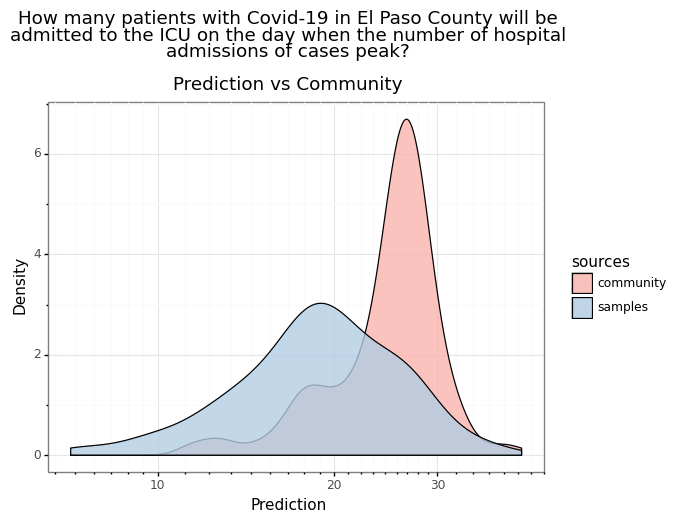

In [20]:
@question(4204)
def peak_icu_admissions():
    """
    How many patients with Covid-19 in El Paso County will be admitted to the
    ICU on the day when the number of hospital admissions of cases peak?

    Following @Tamay's approach:
    https://pandemic.metaculus.com/questions/4204/

    Alternative:    
    - peak = peak_hospitalizations_date()
    - return daily_icu_admissions(peak)

    FIXME: Admissions vs in-hospital patients unclear

    Not mixing in community since this is just the product of two other questions.    
    """
    max_patients = max_30d_hospital_confirmed_for_peak()
    return max_patients * frac_patients_icu()
plot_question(peak_icu_admissions)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,133.0,25.20,5.56,15.00,25.00,25.00,25.00,69.00
frac_patients_icu,200.0,0.30,0.10,0.00,0.24,0.31,0.38,0.61
max_30d_hospital_confirmed_for_peak,200.0,206.75,1407.23,3.01,65.00,65.00,65.00,15901.42
peak_icu_admissions,200.0,61.88,418.51,0.37,15.29,19.78,24.92,4658.12
peak_invasive_ventilation,200.0,32.41,220.62,0.19,7.70,10.14,12.95,2424.25


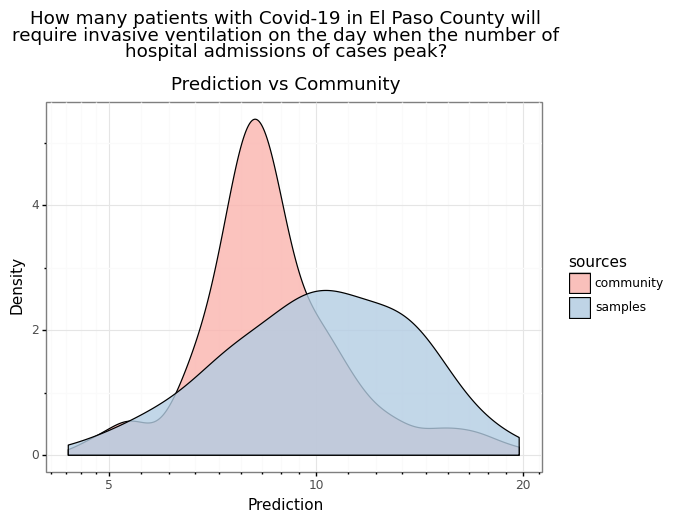

In [21]:
@question(4201)
def peak_invasive_ventilation():
    """
    How many patients with Covid-19 in El Paso County will require invasive 
    ventilation on the day when the number of hospital admissions of cases 
    peak?

    Following @Tamay's approach:
    https://pandemic.metaculus.com/questions/4201/#comment-28004

    Not mixing in community since this is just the product of two other questions.
    """
    return frac_icu_ventilation() * peak_icu_admissions()

plot_question(peak_invasive_ventilation)

# Generate predictions for all questions

In [22]:
def model():
    clear_mem()
    for sampler in samplers.values():
        sampler()

samples = ergo.run(model, num_samples=2000)

summarize_question_samples(samples)

,count,mean,std,min,25%,50%,75%,max
peak_infection_date,2000.0,26.20,11.47,14.00,25.00,25.00,25.00,142.00
peak_infections,2000.0,101.09,440.36,0.00,47.00,72.34,74.00,7543.98
mean_infections_peak345,2000.0,44.91,205.86,0.00,25.67,31.67,31.67,3857.23
mean_infections_peak678,2000.0,48.90,237.60,0.00,16.40,22.80,30.84,3686.06
frac_patients_icu,2000.0,0.30,0.10,0.00,0.23,0.29,0.36,0.85
frac_patients_invasive,2000.0,0.15,0.06,0.00,0.11,0.15,0.19,0.87
max_30d_hospital_confirmed_for_peak,2000.0,101.85,602.46,1.11,65.00,65.00,65.00,14871.46
peak_icu_admissions,2000.0,30.40,181.50,0.00,14.67,19.04,23.66,5179.12
peak_invasive_ventilation,2000.0,15.38,90.07,0.00,7.44,9.65,12.21,2513.48


# Compare predictions to community

This takes a while since we're fitting a mixture of logistic distributions to our samples before visualizing (and submitting) them.
These may look a little different from the plots below the questions above, because we've taken more samples from the distribution and we're fitting logistic distributions so we can submit them to metaculus

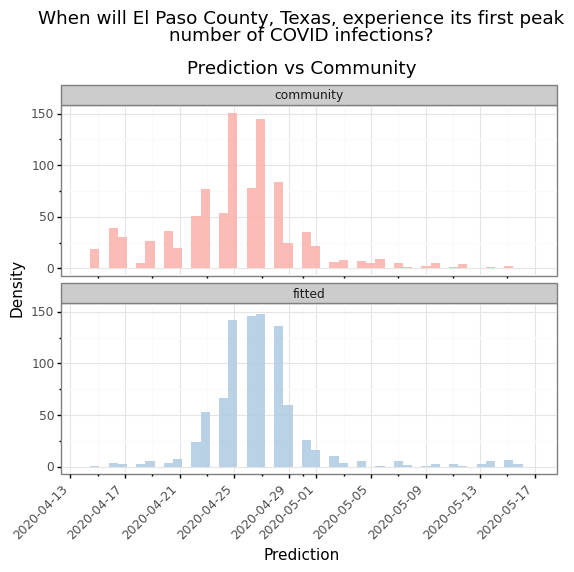

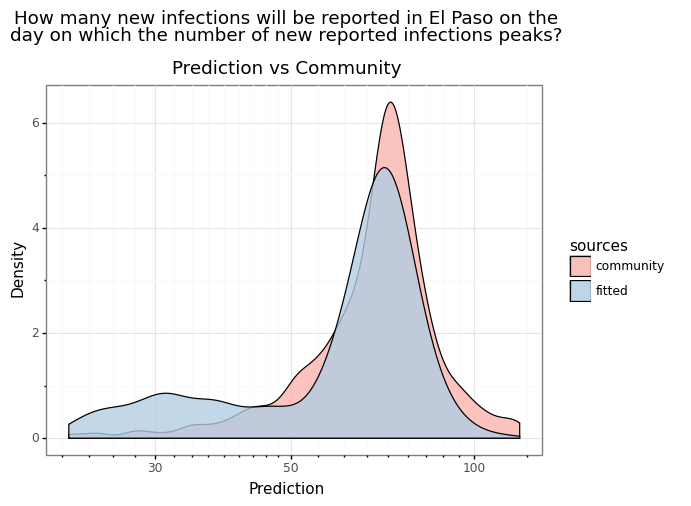

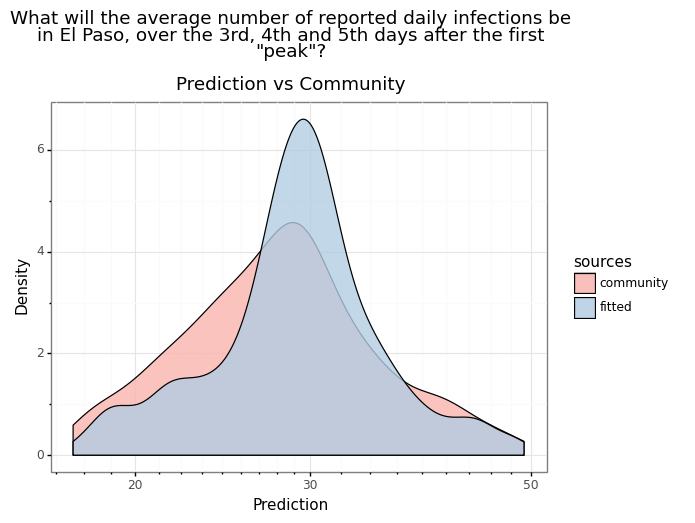

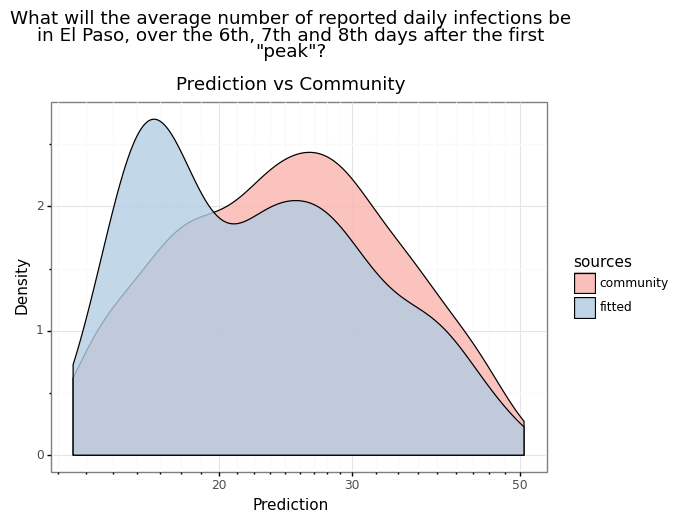

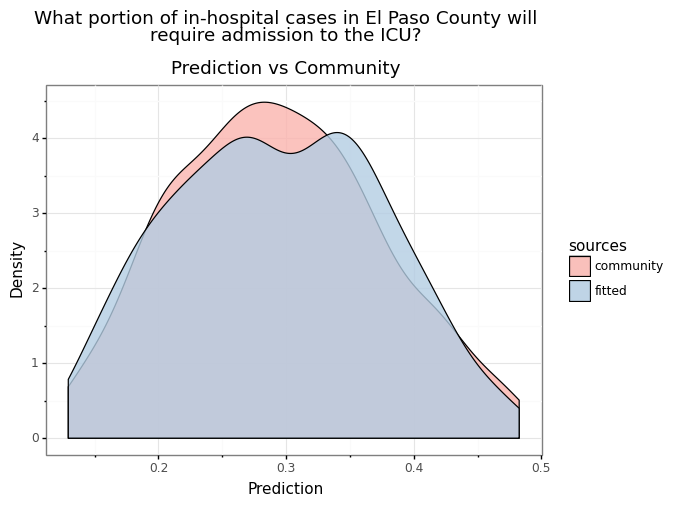

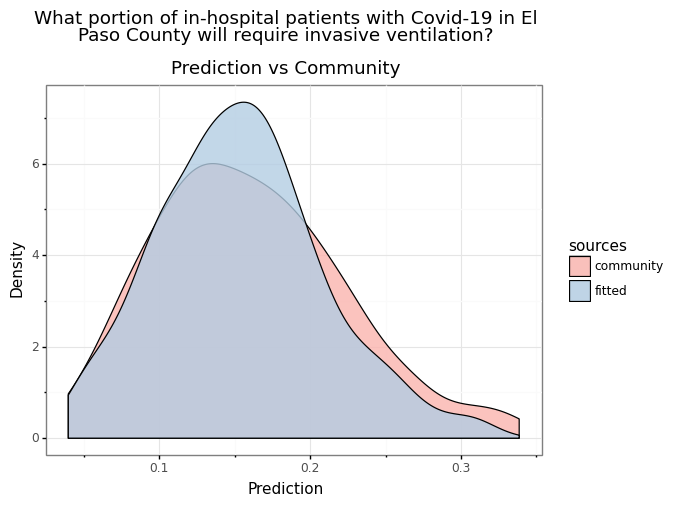

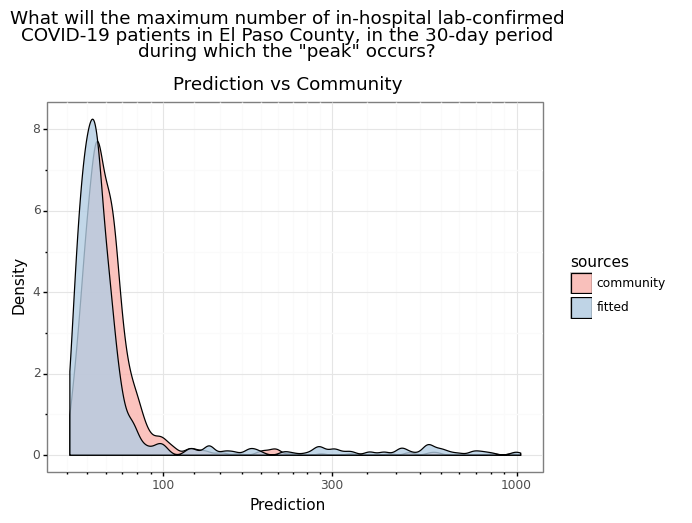

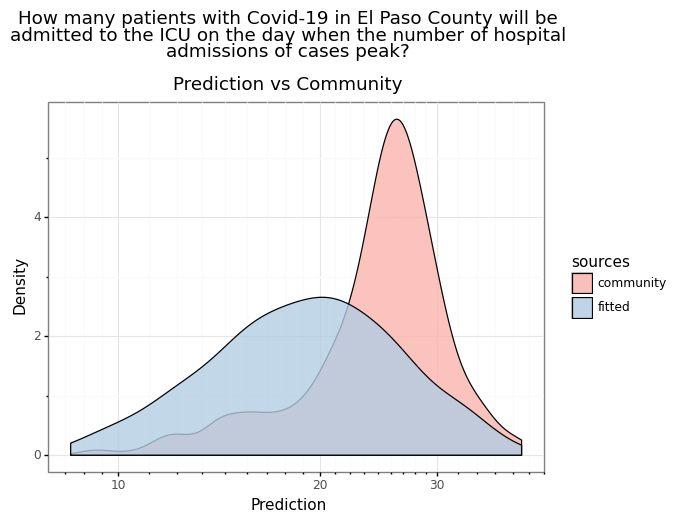

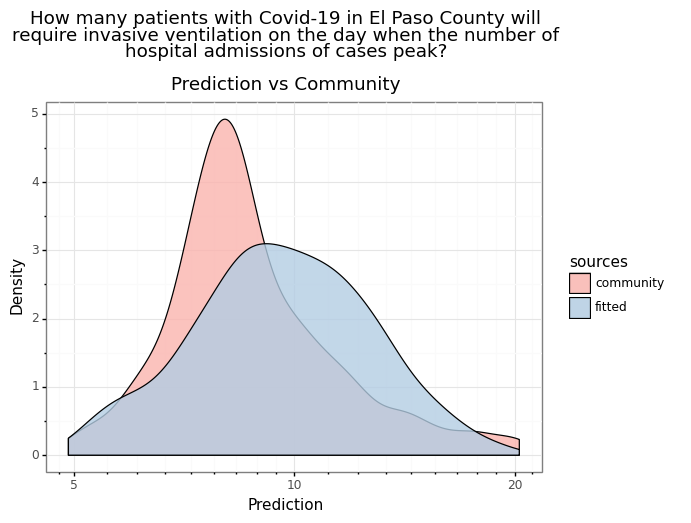

In [23]:
submissions = {}
for sampler in samplers.values():
    q = sampler.question

    q_samples = samples[sampler.__name__]

    if q.id == 4128: # Date question: Need to convert back to date from days (https://github.com/oughtinc/ergo/issues/144)
        q_samples = np.array([START_DATE + timedelta(s) for s in q_samples])

    if q.id in [4201, 4204, 4137, 4152, 4170, 4153]:
      # Clip extreme values for questions that we had issues fitting
      (sample_min, sample_max) = np.quantile(q_samples, [0.02, 0.98])
      q_samples = q_samples[(q_samples >= sample_min) & (q_samples <= sample_max)]

    submission = q.get_submission_from_samples(q_samples)
    submissions[q] = submission

    # the graph for this question will be too zoomed out unless we cut off more of the graph
    if q.id == 4153:
      q.show_prediction(q_samples, plot_samples=False, plot_fitted=True, show_community=True, percent_kept=0.7)
    else:
      q.show_prediction(q_samples, plot_samples=False, plot_fitted=True, show_community=True, percent_kept=0.9)

In [0]:
# Should we submit this to Metaculus? If so, uncomment the following lines:
# for q, submission in submissions.items():  
#     print(q.submit(submission))